# __Part IV: Sentiment analysis and Suggestions__

## __Import Libraries and Data__

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from collections import Counter
import contractions
from textblob import TextBlob
from textblob.np_extractors import ConllExtractor
from wordcloud import WordCloud

import utils

In [2]:
# Set dataframe display
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', -1)

In [3]:
# Define path of data
data_folder = "C:\\Users\\DoZoYo\\OneDrive - Mahidol University\\611 Advanced ML\\Sentiment Analysis\\data\\"
img_folder = "C:\\Users\\DoZoYo\\OneDrive - Mahidol University\\611 Advanced ML\\Sentiment Analysis\\img\\"

In [4]:
# Load training, validation, and test data set
file_list = ['df_sentiment','X_comment','token','cleaned',
             'X','y',
             'y_pred_all', 'y_prob_all',
             'word_index', 'vocab_size'
            ]
files = utils.load_np(data_folder, file_list)

## __Sentiment Analysis__

In [5]:
df_analyse = pd.DataFrame(np.concatenate((files['df_sentiment'], 
                                          files['cleaned'].reshape(files['df_sentiment'].shape[0],1),
                                          files['y_pred_all']), axis=1), 
                          columns=['comment_th','comment_eng','score','y','hospital','cleaned_text','y_pred'])
df_analyse['y_pred'] = df_analyse['y_pred'].apply(lambda x: -1 if x==0 else x)

df_overview = df_analyse[['hospital','comment_eng','y_pred']]
df_rama = df_analyse[(df_analyse['hospital']=='corpus_rama')]
df_siriraj = df_analyse[(df_analyse['hospital']=='corpus_siriraj')]
df_chula = df_analyse[(df_analyse['hospital']=='corpus_chula')]

print('Total comments: {}'.format(df_analyse.shape[0]))
print('Comments of Ramathibodi: {}'.format(df_rama.shape[0]))
print('Comments of Siriraj: {}'.format(df_siriraj.shape[0]))
print('Comments of Chulalongkorn: {}'.format(df_chula.shape[0]))

Total comments: 649
Comments of Ramathibodi: 222
Comments of Siriraj: 130
Comments of Chulalongkorn: 297


In [6]:
# Method for expand text i.e., don't => do not
def expand_text(column):
    CONTRACTION_MAP = contractions.contractions_dict
    expanded = pd.Series(column).replace(to_replace = CONTRACTION_MAP, regex=True)
    return expanded

# Method for extract noun phrases of each comment using ConllExtractor() model
#     and counting the frequency of the individual noun phrase
def count_np(column):
    pool = column.str.cat(sep=' ')
    dict_count = TextBlob(pool.lower() ,np_extractor=ConllExtractor()).np_counts
    return dict_count

# Method for sorting for descending order of the noun phrases according to their frequency
def sort_np(dict_count):
    sorted_np = sorted(dict_count.items(), key=lambda kv: kv[1], reverse=True)
    return sorted_np

# Build wordcloud
def create_wordcloud(comment_col, y_pred_col):
    wc = {}
    labels = [1,-1]
    
    for label in labels:
        
        if label == 1:
            title_class = 'POSITIVE'
            colormap = 'gist_rainbow'
            background_color = 'white'
        else:
            title_class = 'NEGATIVE'
            colormap = 'plasma'
            background_color = 'black'
        
        # Separate comments according to the predicted class 
        div_class = comment_col[(y_pred_col==label)].values.tolist()
        
        # Expand text
        expanded = expand_text(div_class)
        
        # Summation of frequency of individual noun phrase
        dict_count = count_np(expanded)
        
        # Include only noun phrases with frequency more than 1 times if possible
        if max(dict_count.values()) > 1 :
            dict_count2 = {key:value for (key,value) in dict_count.items() if value > 1}
            
            # Remove name entity
            np_count = {key:value for (key,value) in dict_count2.items() 
                        if key not in ['siriraj hospital','ramathibodi hospital','rama hospital','chula hospital','chulalongkorn hospital']}
            
            # Sorting by descending order of the frequency
            sorted_np = sort_np(np_count)

            # Create and visualize word cloud for these noun phrase
            wc[str(title_class)] = WordCloud(width=600, height =400, 
                                             relative_scaling=1,
                                             max_words=20, colormap=colormap, 
                                             background_color= background_color).generate_from_frequencies(np_count)
            plt.figure()
            plt.imshow(wc[str(title_class)], interpolation='bilinear')
            plt.axis("off")
            plt.title(title_class)        
            plt.show()
        
        else:
            # Remove name entity
            np_count = {key:value for (key,value) in dict_count.items() 
                        if key not in ['siriraj hospital','ramathibodi hospital','rama hospital','chula hospital','chulalongkorn hospital']}
            
            # Create and visualize word cloud for these noun phrase
            wc[str(title_class)] = WordCloud(width=600, height =400, 
                                             relative_scaling=1,
                                             max_words=20, colormap=colormap, 
                                             background_color= background_color).generate_from_frequencies(np_count)
            plt.figure()
            plt.imshow(wc[str(title_class)], interpolation='bilinear')
            plt.axis("off")
            plt.title(title_class)        
            plt.show()
            
            print('Noun phrases are not repeated more than 1 times\n{}'.format(dict_count))
        
    return wc

## Overview for all 3 hospitals
&emsp;&emsp;&emsp; According to the word cloud as depicted below, patients apprecipated the good service of all 3 hospital but they had controversy about waiting time.

Total comments: 649


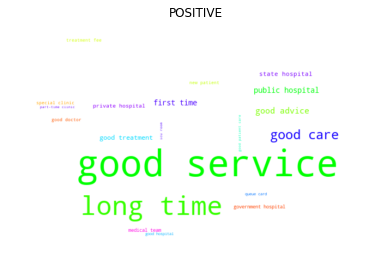

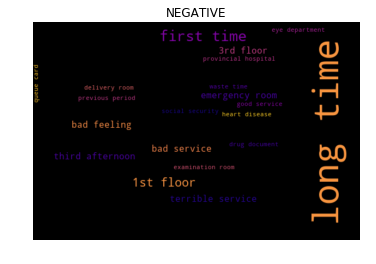

In [7]:
print('Total comments: {}'.format(df_analyse.shape[0]))
wc_overall = create_wordcloud(df_overview['comment_eng'], df_overview['y_pred'])
wc_overall['POSITIVE'].to_file(img_folder + 'wc_overall_pos.png')
wc_overall['NEGATIVE'].to_file(img_folder + 'wc_overall_neg.png')

## 1 Ramathibodi Hospital
&emsp;&emsp;&emsp; The most frequency of noun phrase appeared in negative comments is 'long time'. However, there are some controversy of taking long time and not taking long time, which the phrase, 'long time', appeared in both positive and negative comments. Therefore, the comments which are contained 'long time' should be explored. 
<br>
&emsp;&emsp;&emsp; After driling down, it found that the service takes long time due to a lot of patients. But it could be less waiting time if patients make an appointment to the clinic in advance or online register. Therefore, promoting the online registration and appointment systems will improve the waiting time. It can be promoted via several channels such as video clips, sign, and auto answer system. 
<br>
&emsp;&emsp;&emsp; Moreover, most of these comments which contained 'long time', the patients also mentioned about poor service of nurses. There are several solutions to solve this problem such as service mind training and recruiting more nurses. First, nurses should be trained about service mind for professional care at least once a year to improve skill and remind them. Nurses should treat patients as same as they treat their own relatives. In addition, more nurses should be recruited because the number of patients are rising. Work overload could cause nurses losing temper and affect on bad patient care.

Comments of Ramathibodi: 222


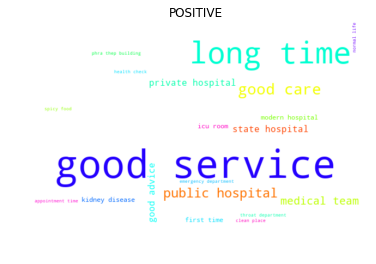

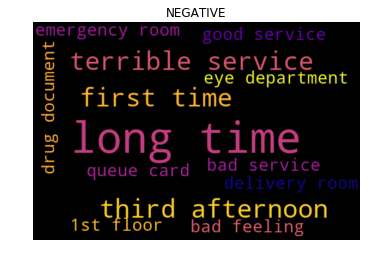

In [8]:
# Ramathibodi
print('Comments of Ramathibodi: {}'.format(df_rama.shape[0]))
wc_rama = create_wordcloud(df_rama['comment_eng'], df_rama['y_pred'])
wc_rama['POSITIVE'].to_file(img_folder + 'wc_rama_pos.png')
wc_rama['NEGATIVE'].to_file(img_folder + 'wc_rama_neg.png')

## 2 Siriraj Hospital
&emsp;&emsp;&emsp; The most noun phrases appeared in positive comments is 'good service' and 'long time'. Surprisingly, patients talk about 'long time' in term of positive comments which is opposite to my knowledge about long waiting time of public hospital.
<br>
&emsp;&emsp;&emsp; After driling down, it found that most patients do not need to wait for a long time because they made an in advanced appointment and came before the appointment time. It implies that Siriraj hospital has efficiently widespread anouncement about the appointment system. This should be a prototype for other hospital.
<br>
&emsp;&emsp;&emsp; However, there are only 7 negative comments of Siriraj hospital and no noun phrase which is repeated more than 1 times. Therefore, more data should be obtained for further analysis in the future.

Comments of Siriraj: 130


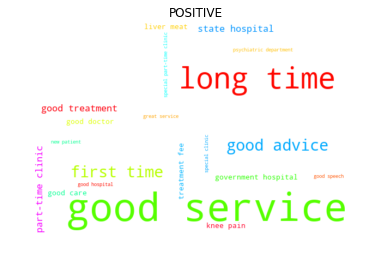

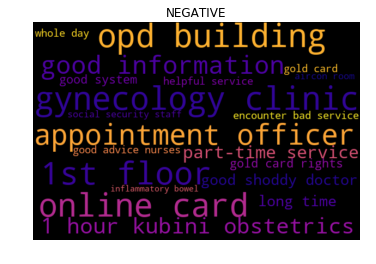

Noun phrases are not repeated more than 1 times
defaultdict(<class 'int'>, {'gynecology clinic': 1, 'online card': 1, 'opd building': 1, '1st floor': 1, 'appointment officer': 1, 'good information': 1, '1 hour kubini obstetrics': 1, 'part-time service': 1, 'good shoddy doctor': 1, 'long time': 1, 'gold card rights': 1, 'good system': 1, 'good advice nurses': 1, 'helpful service': 1, 'gold card': 1, 'whole day': 1, 'encounter bad service': 1, 'social security staff': 1, 'aircon room': 1, 'inflammatory bowel': 1, 'long queue': 1, 'low time': 1, 'day time': 1, 'sataporn lep san': 1, 'bangbon area': 1, 'social security': 1, 'bangpakok hospital 8': 1, 'previous period': 1, 'last bangpakok 8': 1, 'bang pakok': 1, 'specialized doctor': 1, 'one full month': 1, 'weight loss': 1, 'same place': 1, 'direct advice': 1, 'anesthesia feeling anxious': 1, 'blood test first': 1, 'next day': 1, 'operation day': 1, 'salt water': 1, 'salt water line': 1, 'irritable feeling': 1, 'neck injury': 1, 'final fev

In [9]:
# Siriraj
print('Comments of Siriraj: {}'.format(df_siriraj.shape[0]))
wc_siriraj = create_wordcloud(df_siriraj['comment_eng'], df_siriraj['y_pred'])
wc_siriraj['POSITIVE'].to_file(img_folder + 'wc_siriraj_pos.png')
# wc_siriraj['NEGATIVE'].to_file(img_folder + 'wc_siriraj_neg.png')

## 3 Chulalongkorn Hospital
&emsp;&emsp;&emsp; The common noun phrases appeared in negative comments is 'long time'. Most patients complaint about bad system leading to prolong wating time, so the hospital should improve their workflow. In addition, although patients had an appointment, they also complaint about waiting time for patient ID card (PID). Therefore, one method to reduce waiting time is to prepare the PID for the patients who had an appointment.

Comments of Chulalongkorn: 297


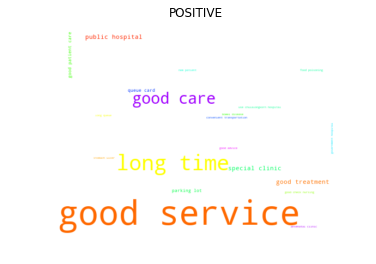

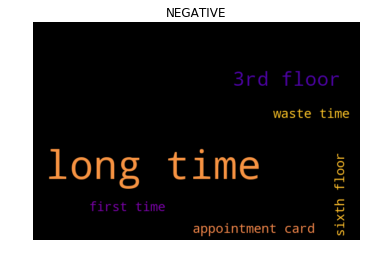

In [10]:
# Chulalongkorn
print('Comments of Chulalongkorn: {}'.format(df_chula.shape[0]))
wc_chula = create_wordcloud(df_chula['comment_eng'], df_chula['y_pred'])
wc_chula['POSITIVE'].to_file(img_folder + 'wc_chula_pos.png')
wc_chula['NEGATIVE'].to_file(img_folder + 'wc_chula_neg.png')

## __Suggestion__

&emsp;&emsp;&emsp; All above results come from prediction of my model which extracts features by using 64 filters of one (1x3) CNN. It may miss classify or lose some other issues due to the performance of model (ROC = 84.43%, PR-curve=95.65%). Therefore, discussion with my colleagues who created other predictive models for the same purpose and predict the same dataset could give better suggestions compared to using the result obtained from one predictive model.
<br>

&emsp;&emsp;&emsp; After discussing with the team, __the main problem of these hospitals (Ramathibodi, Siriraj, and Chulalongkorn) are about waiting time__ which can be categorized based on the workflow processess of public hospital such as _**waiting for patient registration, waiting to see doctor, waiting for medications, and waiting for laboratory results**_. These processes are independence, so it should have different solutions to reduce the waiting time.
<br>
> _Waiting for patient registration_ <br>
&emsp;&emsp; A lot of information need to be input i.e., citizen identification (CID), date of birth, name, parents' name, history of allergies resulting in taking long time to fill in the blank form. However, for Thai citizen, they have a smart card which already store their personal information. Therefore, if the hospital could link to the database of the smart card, it would reduce time of registration. For example, patients key their own CID number into the online registration then filling the other information into the form, or patients just put their own smart card to a computer if it's inconvenient for them to register on website.
<br><br>
> _Waiting to see doctor_ 
<br>
&emsp;&emsp; Because the 3 hospitals are trusty and famous public hospitals in Thailand, a large number of patients want to be treated at these hospitals. Whereas number of doctors are small compared to number of patients. So patients will take long time to wait for the doctor. There are several ways to improve this problem as follows: 
<br>
&nbsp; - Most patients come with mild symptoms or common diseases that could be cured by the doctors at primary care units. They should be educated that these 3 hospitals are tertiary care units which deserve treatment for complex or rare diseases in order to reduce number of patients at the three hospitals. 
<br>
&nbsp; - Doctors should be encouraged to work at primary units. 
<br>
&nbsp; - Development and promotion of primary care units should be done in order to ensure that patients will recieve a good treatment as well as they go to the tertiary care. 
<br>
&nbsp; - Even thought number of patients with mild symptoms are decreasing, patients with complex diseases still be abundant compared to number of doctors. Recruitment more doctors might be another solution in order to increase number of doctors.
<br>
&nbsp; - Improvement appointment system also decreases the waiting time. When patients have an appointment, the appointed time should be accurate and reliable. For example, if the appointed time said 5pm, the patient should see doctor at that time. 
<br><br>
> _Waiting for medications_ 
<br>
&emsp;&emsp; Because current prescription system is still manual by using handwritten, it will take time for process of transcription. Therefore, using computerized physician order entry (CPOE) system might help to reduce waiting time and prescription error.
<br><br>
>&emsp;&emsp; Moreover, a status notification system should be developed which could tell patients about their status. For example, hospital develops a mobile application to tell patients what their queue status is and estimate time for waiting. This will help the patients not to be stuck at the clinic all the time. In addition, setting up monitors at many areas to display the queue number of patient who are seeing doctor. Therefore, patients will know well that healthcare teams are not lying down on the job. This can make patients feel better than they wait without any information.

&emsp;&emsp;&emsp; Besides, __Ramathibodi and Chula hospital are commonly complaint about first time experience__ because new patients knew nothing about the workflow processes of the hospitals. Without knowledge about the workflow could make patients being upset. Therefore, introducing the workflow of service is an important method to solve this problem. The steps of service might be summarized in one page of poster standing in many area of hospital. Infographic technique might be used to create an interesting poster with clear captions. In addition, hospital might create a short video to intrduce steps of service and broadcast over the internet, or replay the tutorial via an internal network. Moreover, the healthcare providers should improve their communication skills to give a friendly advice to patients. Furthermore, the providers might recruit specific employees or assign employees to be guides of hospital.
<br>

&emsp;&emsp;&emsp; Additionally, __Ramathibodi is highly complaint about poor service__. This situation could happen because the ratio of patients to healthcare providers is very high resulting in work overload and restless sleep. Therefore, the hospital should recruit more staffs. In addition, service mind training should be done yearly to remind them. All staffs should realize that they must treat all patients the same as their relatives.
<br>

&emsp;&emsp;&emsp; However, there is no complaint about waiting for laboratory results. The reason is that most of laboratory test are done prior to see the doctor, and the patients do not need to wait for the laboratory results on that day. Therefore, it could be less complaint compared to other processes. Moreover, these complaints come from only one database which might not represent to entire patient satisfaction. Therefore, more data should be included for further analysis.